# **I am a bit of monet too - A GAN Model**

This mini project involves building and training a generative deep learning models using GAN( generative Adversarial Neural Network). I have chosen to train the model to generate fake images for monet. The kaggle requirement was to implement image to image translation using Cycle GAN. But it also mentions that it is okay to generate images that are not translated.

I have created Generator and Discriminator architechture by follwing CDGAN specification according to which we should use Conv2D layers for Generator and Relu activation except Tanh at the last Dense layer. BatchNormalizations are added after each Conv2D to improve the performance.
The generator model starts by accepting a random noise of 1x4096 and applies multiple convolutions and finally resulting an image of size 256x256 with RGB channels.

The discriminator also follows CDGAN Specification and uses Conv2D layers with leakyRelu activation. It starts by taking a real/fake image as input and generates a binary classification output. 
The generator and discriminator are combined together in a GAN model and pitted against each other to eventually have generator trained to the level where it geenrates fake images as close to real as possible and leads to confusing discriminator in judging between real and fake images.

The hyperparameters for all the models uses ADAM optimizer with a learning rate of 1e-4 and loss as binary crossentropy.

The training is performed for 100 epoch and output images are generated at frequent interval. Finally once the training is over, a few thousand images are generated and combined in a zip to create desired output.


In [1]:
# import required packages.
import tensorflow as tf

from tensorflow.keras.layers import Dense, Conv2DTranspose, Dropout, Conv2D
from tensorflow.keras.layers import Input, BatchNormalization,Activation,Reshape, Flatten, ReLU, LeakyReLU,UpSampling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
import random
import os
import glob
import numpy as np
import pandas as pd
import zipfile
import gzip
import io
from tqdm import tqdm

import PIL
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

2024-06-23 22:32:22.435782: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 22:32:22.435892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 22:32:22.562618: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Setup GPU accelerator - configure Strategy. Assume TPU...if not set default for GPU/CPU
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

In [3]:
# set working and output directory
WORKING_DIR = '/kaggle/input/gan-getting-started'
OUTPUT_DIR = '/kaggle/working/'
train_dir = WORKING_DIR + "/monet_jpg"

# **Exploratory Data Analysis**

In [4]:
# check the number of images
_, _, files = next(os.walk(train_dir))
file_count = len(files)
print(file_count)

300


In [5]:
# check if all the images have same shape
width,height,channel = 256,256,3
count_img_not_std = 0
ids = []
_, _, files = next(os.walk(train_dir))
for i, file in enumerate(files):
    im = cv2.imread(train_dir + '/' + file)    
    if width != im.shape[0] or  height != im.shape[1] or channel != im.shape[2]:
        count_img_not_std =  count_img_not_std + 1
        ids.append(i)
print('number of images with different shape:', count_img_not_std)

number of images with different shape: 0


In [6]:
# set the image shape for use in generator and discriminator models.
img_shape = (width,height,channel)

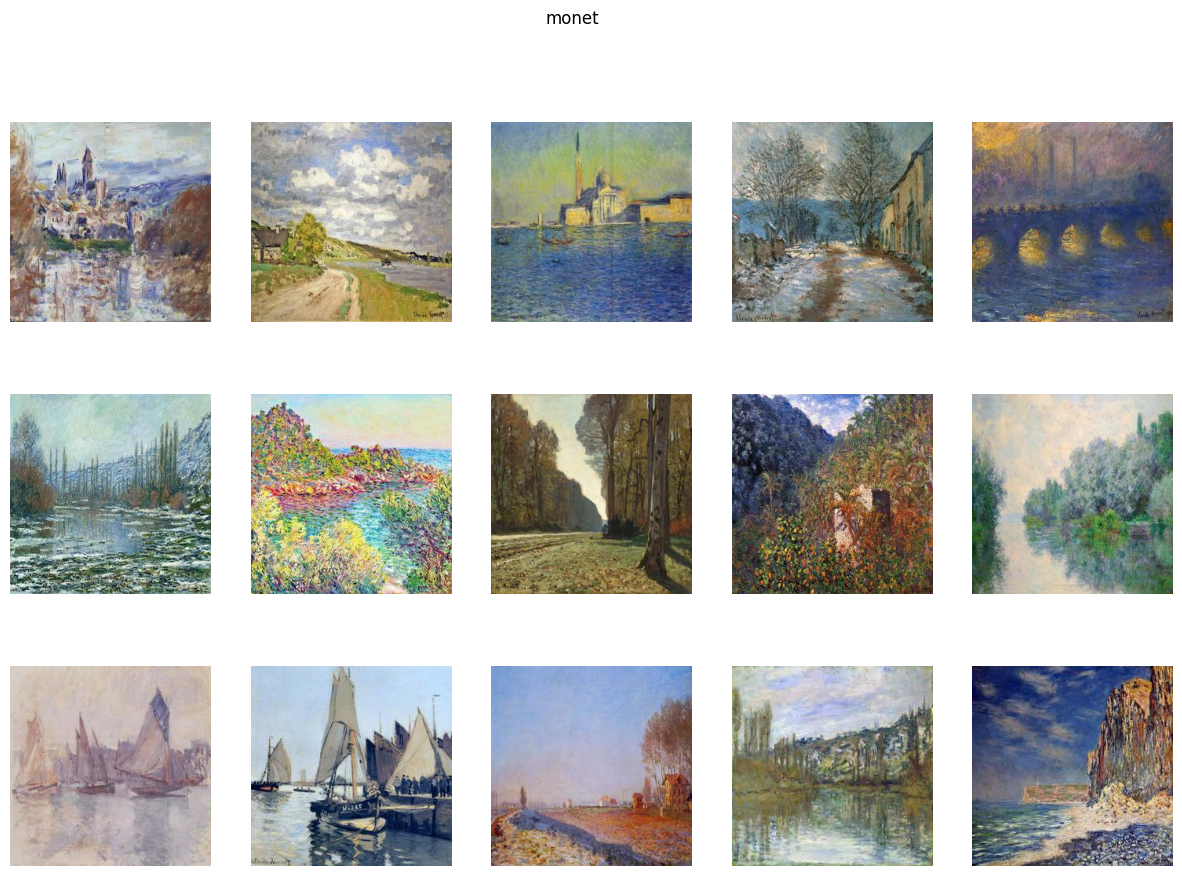

In [7]:
# inspect some random images
def show_images(paths):
    plt.figure(figsize=(15, 10))
    for i,path in enumerate(paths):
        img = Image.open(path)
        rows = 3
        columns = int(len(paths)/rows)
        plt.subplot(rows, columns, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle('monet')
    plt.show()
    
file_path_type = ['/kaggle/input/gan-getting-started/monet_jpg/*.jpg']
images = glob.glob(random.choice(file_path_type))
random_images = []
for i in range(15):
    random_image = random.choice(images)
    random_images.append(random_image)
show_images(random_images)


In [8]:
# create a numpy array of images. Normalize each image on (-1,1) scale
X_monet = []

_, _, files = next(os.walk(train_dir))
for i,file in enumerate(files):
    img = Image.open(train_dir + '/' + file)
    image_as_array = np.asarray(img)
    scaled_image = (image_as_array.astype(np.float32) - 127.5) / 127.5
    X_monet.append(scaled_image)

print(len(X_monet))
print(X_monet[0])

X_train = np.array(X_monet)

300
[[[-0.52156866 -0.69411767 -1.        ]
  [-0.60784316 -0.7490196  -1.        ]
  [-0.49019608 -0.6        -0.8745098 ]
  ...
  [-0.34901962 -0.43529412 -0.5764706 ]
  [ 0.2784314   0.1764706   0.02745098]
  [ 0.11372549 -0.00392157 -0.16862746]]

 [[-0.52156866 -0.7019608  -0.96862745]
  [-0.4509804  -0.60784316 -0.8666667 ]
  [-0.60784316 -0.7254902  -0.96862745]
  ...
  [-0.1764706  -0.23921569 -0.3882353 ]
  [ 0.11372549  0.01176471 -0.13725491]
  [-0.11372549 -0.20784314 -0.38039216]]

 [[-0.22352941 -0.43529412 -0.6       ]
  [-0.31764707 -0.49019608 -0.654902  ]
  [-0.64705884 -0.78039217 -0.92156863]
  ...
  [-0.15294118 -0.20784314 -0.34901962]
  [-0.03529412 -0.12156863 -0.2627451 ]
  [ 0.08235294 -0.00392157 -0.16078432]]

 ...

 [[-0.2627451  -0.28627452 -0.8117647 ]
  [-0.12156863 -0.14509805 -0.67058825]
  [ 0.24705882  0.22352941 -0.3019608 ]
  ...
  [ 0.08235294 -0.09019608  0.01176471]
  [ 0.16078432 -0.01176471  0.08235294]
  [-0.15294118 -0.31764707 -0.24705882]]

In [9]:
# retrieve the shape of training input for discriminator
X_train.shape

(300, 256, 256, 3)

#  **DCGAN Model and training**

In [10]:
# build generator. A random input of size 4096 is used. 
# It is adviced to use Conv2d Transpose for DCGAN instead of Dense layer. 
# Each Conv2DTranpose layer is accompanied by BatchNormalization for regularization and faster training,
# and 'Relu' activation, except the final layer that uses 'tanh' activation.
# Upsamplings are used to correct imbalanced data and thereby improve model performance. 
def build_generator():

    #1D array of size 4096 (latent vector / noise)     
    noise_shape = (4096,)    
    
    model = Sequential()

    model.add(Reshape(target_shape=[1,1,4096], input_shape=[4096]))

    model.add(Conv2DTranspose(filters = 256, kernel_size = 4))
    model.add(Activation('relu'))

    #4x4x256
    model.add(Conv2D(filters = 256, kernel_size = 4, padding = 'same'))
    model.add(BatchNormalization(momentum = 0.7))
    model.add(Activation('relu'))
    model.add(UpSampling2D())
    
    #8x8x256
    model.add(Conv2D(filters = 128, kernel_size = 4, padding = 'same'))
    model.add(BatchNormalization(momentum = 0.7))
    model.add(Activation('relu'))
    model.add(UpSampling2D())
    
    #16x16x128
    model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
    model.add(BatchNormalization(momentum = 0.7))
    model.add(Activation('relu'))
    model.add(UpSampling2D())
    
    #32x32x64
    model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
    model.add(BatchNormalization(momentum = 0.7))
    model.add(Activation('relu'))
    model.add(UpSampling2D())
    
    #64x64x32
    model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same'))
    model.add(BatchNormalization(momentum = 0.7))
    model.add(Activation('relu'))
    model.add(UpSampling2D())
    
    #128x128x16
    model.add(Conv2D(filters = 8, kernel_size = 3, padding = 'same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D())
    
    #256x256x8
    model.add(Conv2D(filters = 3, kernel_size = 3, padding = 'same'))
    model.add(Activation('tanh'))

    # use Adam optimizer with binary cross-entropy loss.
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4))
    model.summary()
    return model

In [11]:
# build discriminator. Starts wit the 256X256 image recevied from input and generator and classify them as real or fake.
# Hence, the outermost layer is a Dense(1). 
# It is adviced for CDGAN, we should use Conv2D layers with LeakyRelu, (5,5) filter with (2,2) stride and Adam optimizer.
def build_discriminator():

    model = Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=img_shape))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4))
    model.summary()
    return model

build_discriminator()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       524,289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 734,081 (2.80 MB)

 Trainable params: 734,081 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

<Sequential name=sequential, built=True>

In [12]:
# create a GAN model that combines generator and discriminator
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(4096,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4))
    return gan

In [13]:
# plot the generated images at frequent intervals to check generator's state. 
# It involves invoking predict() on generator and normalizing the images back to 0-255
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 4096])
    generated_images = generator.predict(noise)

    norm_images = [cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F).astype(np.uint8) for image in generated_images]
    norm_images = np.asarray(norm_images)
    norm_images = norm_images.reshape(100,256,256,3)
    plt.figure(figsize=figsize)
    for i in range(norm_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(norm_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.savefig(OUTPUT_DIR + '/gan_generated_image %d.png' %epoch)

In [14]:
# utilities for creating zip with generated images.
def get_image_buffer(npa):
    img_buffer = io.BytesIO()
    image = Image.fromarray(npa)
    image.save(img_buffer, 'JPEG')
    img_buffer.seek(0)

    return img_buffer


def get_zip_buffer(images):
    zip_buffer = io.BytesIO()

    with zipfile.ZipFile(zip_buffer, "a", zipfile.ZIP_DEFLATED, False) as zip_file:
        for i, image in enumerate(images):
            zip_file.writestr(str(i) + '.jpg', get_image_buffer(image).read())

    zip_buffer.seek(0)
    return zip_buffer

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 1, 1, 4096)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 4, 4, 256)      │    16,777,472 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 256)      │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64, 64, 16)     │             

 Total params: 18,450,963 (70.38 MB)

 Trainable params: 18,449,971 (70.38 MB)

 Non-trainable params: 992 (3.88 KB)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │       524,289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 734,081 (2.80 MB)

 Trainable params: 734,081 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1


  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


I0000 00:00:1719181985.208045     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
  3%|▎         | 1/32 [00:31<16:26, 31.81s/it]

for epoch: 1
disc_loss: 2.772338
gen_loss: [array(2.7723377, dtype=float32), array(2.7723377, dtype=float32), array(2.7723377, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|▋         | 2/32 [00:37<08:04, 16.15s/it]

for epoch: 1
disc_loss: 1.495616
gen_loss: [array(1.4956162, dtype=float32), array(1.4956162, dtype=float32), array(1.4956162, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  9%|▉         | 3/32 [00:42<05:21, 11.10s/it]

for epoch: 1
disc_loss: 1.615922
gen_loss: [array(1.6159222, dtype=float32), array(1.6159222, dtype=float32), array(1.6159222, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 12%|█▎        | 4/32 [00:47<04:03,  8.70s/it]

for epoch: 1
disc_loss: 1.689882
gen_loss: [array(1.6898818, dtype=float32), array(1.6898818, dtype=float32), array(1.6898818, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 16%|█▌        | 5/32 [00:52<03:19,  7.40s/it]

for epoch: 1
disc_loss: 1.396284
gen_loss: [array(1.396284, dtype=float32), array(1.396284, dtype=float32), array(1.396284, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 19%|█▉        | 6/32 [00:57<02:54,  6.70s/it]

for epoch: 1
disc_loss: 1.168330
gen_loss: [array(1.1683304, dtype=float32), array(1.1683304, dtype=float32), array(1.1683304, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|██▏       | 7/32 [01:02<02:33,  6.15s/it]

for epoch: 1
disc_loss: 1.051985
gen_loss: [array(1.0519851, dtype=float32), array(1.0519851, dtype=float32), array(1.0519851, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|██▌       | 8/32 [01:07<02:20,  5.84s/it]

for epoch: 1
disc_loss: 0.931903
gen_loss: [array(0.9319033, dtype=float32), array(0.9319033, dtype=float32), array(0.9319033, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|██▊       | 9/32 [01:12<02:08,  5.61s/it]

for epoch: 1
disc_loss: 0.832358
gen_loss: [array(0.8323577, dtype=float32), array(0.8323577, dtype=float32), array(0.8323577, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 31%|███▏      | 10/32 [01:17<01:59,  5.45s/it]

for epoch: 1
disc_loss: 0.862779
gen_loss: [array(0.8627786, dtype=float32), array(0.8627786, dtype=float32), array(0.8627786, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 34%|███▍      | 11/32 [01:23<01:52,  5.36s/it]

for epoch: 1
disc_loss: 0.840883
gen_loss: [array(0.84088296, dtype=float32), array(0.84088296, dtype=float32), array(0.84088296, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|███▊      | 12/32 [01:28<01:45,  5.27s/it]

for epoch: 1
disc_loss: 0.839677
gen_loss: [array(0.83967686, dtype=float32), array(0.83967686, dtype=float32), array(0.83967686, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 41%|████      | 13/32 [01:33<01:39,  5.22s/it]

for epoch: 1
disc_loss: 0.797835
gen_loss: [array(0.79783523, dtype=float32), array(0.79783523, dtype=float32), array(0.79783523, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 44%|████▍     | 14/32 [01:38<01:33,  5.20s/it]

for epoch: 1
disc_loss: 0.742289
gen_loss: [array(0.74228895, dtype=float32), array(0.74228895, dtype=float32), array(0.74228895, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████▋     | 15/32 [01:43<01:27,  5.16s/it]

for epoch: 1
disc_loss: 0.732583
gen_loss: [array(0.7325828, dtype=float32), array(0.7325828, dtype=float32), array(0.7325828, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████     | 16/32 [01:48<01:22,  5.14s/it]

for epoch: 1
disc_loss: 0.738890
gen_loss: [array(0.7388897, dtype=float32), array(0.7388897, dtype=float32), array(0.7388897, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|█████▎    | 17/32 [01:53<01:16,  5.12s/it]

for epoch: 1
disc_loss: 0.713655
gen_loss: [array(0.7136547, dtype=float32), array(0.7136547, dtype=float32), array(0.7136547, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 56%|█████▋    | 18/32 [01:58<01:11,  5.12s/it]

for epoch: 1
disc_loss: 0.675629
gen_loss: [array(0.6756294, dtype=float32), array(0.6756294, dtype=float32), array(0.6756294, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████▉    | 19/32 [02:03<01:06,  5.12s/it]

for epoch: 1
disc_loss: 0.654984
gen_loss: [array(0.65498435, dtype=float32), array(0.65498435, dtype=float32), array(0.65498435, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 62%|██████▎   | 20/32 [02:09<01:01,  5.12s/it]

for epoch: 1
disc_loss: 0.634949
gen_loss: [array(0.6349491, dtype=float32), array(0.6349491, dtype=float32), array(0.6349491, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|██████▌   | 21/32 [02:14<00:56,  5.13s/it]

for epoch: 1
disc_loss: 0.617050
gen_loss: [array(0.6170502, dtype=float32), array(0.6170502, dtype=float32), array(0.6170502, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 69%|██████▉   | 22/32 [02:19<00:51,  5.12s/it]

for epoch: 1
disc_loss: 0.625117
gen_loss: [array(0.6251165, dtype=float32), array(0.6251165, dtype=float32), array(0.6251165, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 72%|███████▏  | 23/32 [02:24<00:45,  5.11s/it]

for epoch: 1
disc_loss: 0.623675
gen_loss: [array(0.62367463, dtype=float32), array(0.62367463, dtype=float32), array(0.62367463, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 75%|███████▌  | 24/32 [02:29<00:40,  5.09s/it]

for epoch: 1
disc_loss: 0.631877
gen_loss: [array(0.6318772, dtype=float32), array(0.6318772, dtype=float32), array(0.6318772, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████▊  | 25/32 [02:34<00:35,  5.09s/it]

for epoch: 1
disc_loss: 0.627506
gen_loss: [array(0.627506, dtype=float32), array(0.627506, dtype=float32), array(0.627506, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|████████▏ | 26/32 [02:39<00:30,  5.10s/it]

for epoch: 1
disc_loss: 0.614349
gen_loss: [array(0.6143492, dtype=float32), array(0.6143492, dtype=float32), array(0.6143492, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 84%|████████▍ | 27/32 [02:44<00:25,  5.07s/it]

for epoch: 1
disc_loss: 0.601626
gen_loss: [array(0.6016262, dtype=float32), array(0.6016262, dtype=float32), array(0.6016262, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 88%|████████▊ | 28/32 [02:49<00:20,  5.09s/it]

for epoch: 1
disc_loss: 0.598686
gen_loss: [array(0.59868556, dtype=float32), array(0.59868556, dtype=float32), array(0.59868556, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 29/32 [02:54<00:15,  5.09s/it]

for epoch: 1
disc_loss: 0.579582
gen_loss: [array(0.57958245, dtype=float32), array(0.57958245, dtype=float32), array(0.57958245, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 94%|█████████▍| 30/32 [02:59<00:10,  5.10s/it]

for epoch: 1
disc_loss: 0.569906
gen_loss: [array(0.56990606, dtype=float32), array(0.56990606, dtype=float32), array(0.56990606, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 97%|█████████▋| 31/32 [03:05<00:05,  5.11s/it]

for epoch: 1
disc_loss: 0.552220
gen_loss: [array(0.5522198, dtype=float32), array(0.5522198, dtype=float32), array(0.5522198, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


100%|██████████| 32/32 [03:10<00:00,  5.94s/it]

for epoch: 1
disc_loss: 0.550720
gen_loss: [array(0.5507198, dtype=float32), array(0.5507198, dtype=float32), array(0.5507198, dtype=float32)]
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 723ms/step


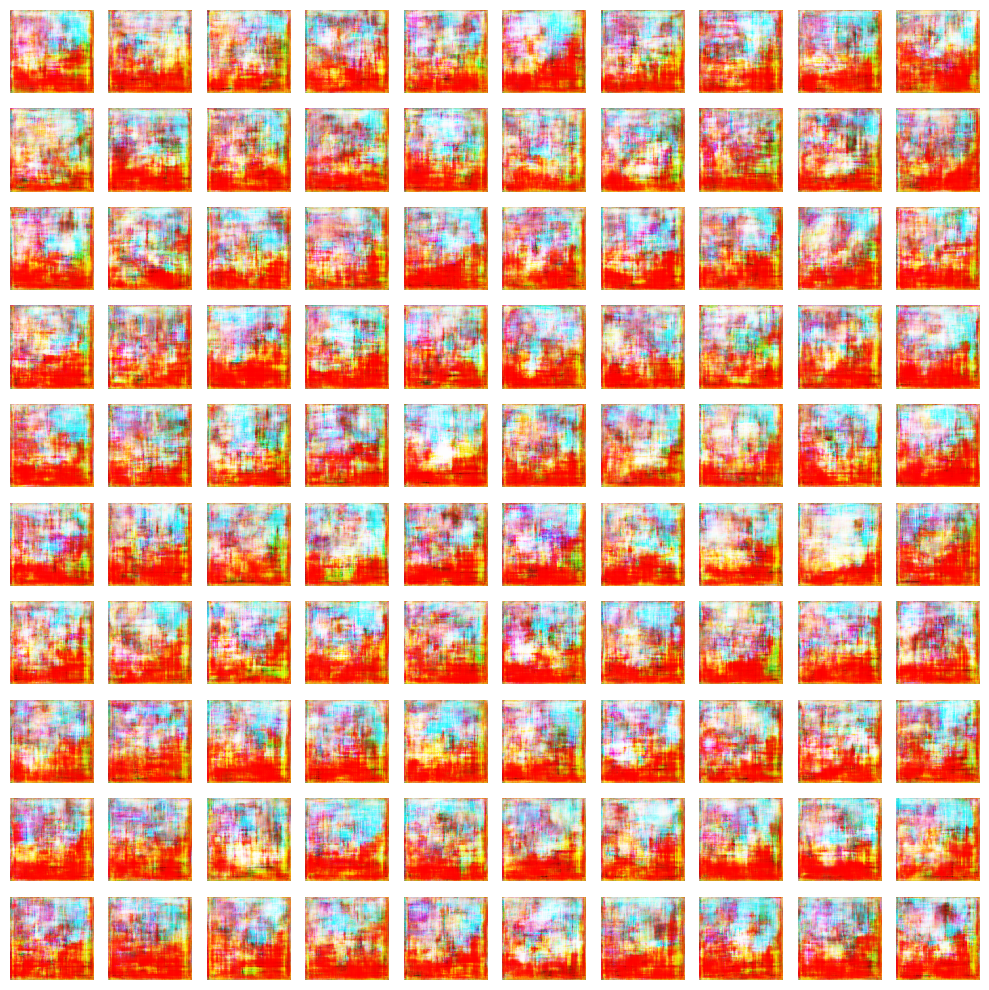

Epoch 2


  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|▎         | 1/32 [00:05<02:37,  5.09s/it]

for epoch: 2
disc_loss: 0.543079
gen_loss: [array(0.54307884, dtype=float32), array(0.54307884, dtype=float32), array(0.54307884, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|▋         | 2/32 [00:10<02:33,  5.12s/it]

for epoch: 2
disc_loss: 0.534786
gen_loss: [array(0.5347861, dtype=float32), array(0.5347861, dtype=float32), array(0.5347861, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  9%|▉         | 3/32 [00:15<02:28,  5.11s/it]

for epoch: 2
disc_loss: 0.534840
gen_loss: [array(0.5348396, dtype=float32), array(0.5348396, dtype=float32), array(0.5348396, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 12%|█▎        | 4/32 [00:20<02:21,  5.06s/it]

for epoch: 2
disc_loss: 0.534548
gen_loss: [array(0.53454787, dtype=float32), array(0.53454787, dtype=float32), array(0.53454787, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 16%|█▌        | 5/32 [00:25<02:17,  5.10s/it]

for epoch: 2
disc_loss: 0.527424
gen_loss: [array(0.5274238, dtype=float32), array(0.5274238, dtype=float32), array(0.5274238, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 19%|█▉        | 6/32 [00:30<02:13,  5.12s/it]

for epoch: 2
disc_loss: 0.514247
gen_loss: [array(0.51424736, dtype=float32), array(0.51424736, dtype=float32), array(0.51424736, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|██▏       | 7/32 [00:35<02:07,  5.11s/it]

for epoch: 2
disc_loss: 0.514051
gen_loss: [array(0.51405126, dtype=float32), array(0.51405126, dtype=float32), array(0.51405126, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 25%|██▌       | 8/32 [00:40<02:02,  5.11s/it]

for epoch: 2
disc_loss: 0.501661
gen_loss: [array(0.5016606, dtype=float32), array(0.5016606, dtype=float32), array(0.5016606, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 28%|██▊       | 9/32 [00:45<01:57,  5.12s/it]

for epoch: 2
disc_loss: 0.489954
gen_loss: [array(0.48995385, dtype=float32), array(0.48995385, dtype=float32), array(0.48995385, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 31%|███▏      | 10/32 [00:51<01:52,  5.11s/it]

for epoch: 2
disc_loss: 0.479389
gen_loss: [array(0.47938937, dtype=float32), array(0.47938937, dtype=float32), array(0.47938937, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|███▍      | 11/32 [00:56<01:47,  5.11s/it]

for epoch: 2
disc_loss: 0.475040
gen_loss: [array(0.4750398, dtype=float32), array(0.4750398, dtype=float32), array(0.4750398, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|███▊      | 12/32 [01:01<01:43,  5.19s/it]

for epoch: 2
disc_loss: 0.470377
gen_loss: [array(0.47037745, dtype=float32), array(0.47037745, dtype=float32), array(0.47037745, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 41%|████      | 13/32 [01:06<01:38,  5.17s/it]

for epoch: 2
disc_loss: 0.471230
gen_loss: [array(0.47122976, dtype=float32), array(0.47122976, dtype=float32), array(0.47122976, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 44%|████▍     | 14/32 [01:11<01:32,  5.16s/it]

for epoch: 2
disc_loss: 0.461196
gen_loss: [array(0.46119604, dtype=float32), array(0.46119604, dtype=float32), array(0.46119604, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 47%|████▋     | 15/32 [01:16<01:27,  5.15s/it]

for epoch: 2
disc_loss: 0.451430
gen_loss: [array(0.45142984, dtype=float32), array(0.45142984, dtype=float32), array(0.45142984, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 50%|█████     | 16/32 [01:22<01:22,  5.15s/it]

for epoch: 2
disc_loss: 0.442893
gen_loss: [array(0.4428931, dtype=float32), array(0.4428931, dtype=float32), array(0.4428931, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|█████▎    | 17/32 [01:27<01:16,  5.13s/it]

for epoch: 2
disc_loss: 0.439030
gen_loss: [array(0.43903044, dtype=float32), array(0.43903044, dtype=float32), array(0.43903044, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 56%|█████▋    | 18/32 [01:32<01:11,  5.14s/it]

for epoch: 2
disc_loss: 0.431101
gen_loss: [array(0.43110147, dtype=float32), array(0.43110147, dtype=float32), array(0.43110147, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 59%|█████▉    | 19/32 [01:37<01:06,  5.13s/it]

for epoch: 2
disc_loss: 0.433662
gen_loss: [array(0.43366188, dtype=float32), array(0.43366188, dtype=float32), array(0.43366188, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 62%|██████▎   | 20/32 [01:42<01:01,  5.14s/it]

for epoch: 2
disc_loss: 0.435136
gen_loss: [array(0.43513626, dtype=float32), array(0.43513626, dtype=float32), array(0.43513626, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 66%|██████▌   | 21/32 [01:47<00:56,  5.14s/it]

for epoch: 2
disc_loss: 0.436430
gen_loss: [array(0.43642974, dtype=float32), array(0.43642974, dtype=float32), array(0.43642974, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 69%|██████▉   | 22/32 [01:52<00:51,  5.14s/it]

for epoch: 2
disc_loss: 0.433143
gen_loss: [array(0.43314326, dtype=float32), array(0.43314326, dtype=float32), array(0.43314326, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 72%|███████▏  | 23/32 [01:58<00:46,  5.15s/it]

for epoch: 2
disc_loss: 0.425901
gen_loss: [array(0.42590064, dtype=float32), array(0.42590064, dtype=float32), array(0.42590064, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 75%|███████▌  | 24/32 [02:03<00:41,  5.16s/it]

for epoch: 2
disc_loss: 0.427603
gen_loss: [array(0.42760262, dtype=float32), array(0.42760262, dtype=float32), array(0.42760262, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 78%|███████▊  | 25/32 [02:08<00:36,  5.16s/it]

for epoch: 2
disc_loss: 0.424955
gen_loss: [array(0.42495474, dtype=float32), array(0.42495474, dtype=float32), array(0.42495474, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 81%|████████▏ | 26/32 [02:13<00:30,  5.17s/it]

for epoch: 2
disc_loss: 0.421970
gen_loss: [array(0.4219701, dtype=float32), array(0.4219701, dtype=float32), array(0.4219701, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 84%|████████▍ | 27/32 [02:18<00:25,  5.18s/it]

for epoch: 2
disc_loss: 0.414818
gen_loss: [array(0.41481808, dtype=float32), array(0.41481808, dtype=float32), array(0.41481808, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 88%|████████▊ | 28/32 [02:24<00:20,  5.20s/it]

for epoch: 2
disc_loss: 0.408584
gen_loss: [array(0.40858412, dtype=float32), array(0.40858412, dtype=float32), array(0.40858412, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████ | 29/32 [02:29<00:15,  5.20s/it]

for epoch: 2
disc_loss: 0.406560
gen_loss: [array(0.4065597, dtype=float32), array(0.4065597, dtype=float32), array(0.4065597, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 94%|█████████▍| 30/32 [02:34<00:10,  5.21s/it]

for epoch: 2
disc_loss: 0.404189
gen_loss: [array(0.40418908, dtype=float32), array(0.40418908, dtype=float32), array(0.40418908, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 97%|█████████▋| 31/32 [02:39<00:05,  5.20s/it]

for epoch: 2
disc_loss: 0.401771
gen_loss: [array(0.40177095, dtype=float32), array(0.40177095, dtype=float32), array(0.40177095, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


100%|██████████| 32/32 [02:44<00:00,  5.15s/it]


for epoch: 2
disc_loss: 0.395580
gen_loss: [array(0.39557967, dtype=float32), array(0.39557967, dtype=float32), array(0.39557967, dtype=float32)]
Epoch 3


  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 1/32 [00:05<02:40,  5.19s/it]

for epoch: 3
disc_loss: 0.389494
gen_loss: [array(0.38949382, dtype=float32), array(0.38949382, dtype=float32), array(0.38949382, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|▋         | 2/32 [00:10<02:35,  5.18s/it]

for epoch: 3
disc_loss: 0.387408
gen_loss: [array(0.38740823, dtype=float32), array(0.38740823, dtype=float32), array(0.38740823, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|▉         | 3/32 [00:15<02:29,  5.17s/it]

for epoch: 3
disc_loss: 0.381626
gen_loss: [array(0.38162604, dtype=float32), array(0.38162604, dtype=float32), array(0.38162604, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 12%|█▎        | 4/32 [00:20<02:25,  5.20s/it]

for epoch: 3
disc_loss: 0.376014
gen_loss: [array(0.37601388, dtype=float32), array(0.37601388, dtype=float32), array(0.37601388, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 16%|█▌        | 5/32 [00:25<02:20,  5.19s/it]

for epoch: 3
disc_loss: 0.370851
gen_loss: [array(0.37085122, dtype=float32), array(0.37085122, dtype=float32), array(0.37085122, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▉        | 6/32 [00:31<02:15,  5.19s/it]

for epoch: 3
disc_loss: 0.365553
gen_loss: [array(0.36555335, dtype=float32), array(0.36555335, dtype=float32), array(0.36555335, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|██▏       | 7/32 [00:36<02:10,  5.20s/it]

for epoch: 3
disc_loss: 0.360405
gen_loss: [array(0.3604047, dtype=float32), array(0.3604047, dtype=float32), array(0.3604047, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|██▌       | 8/32 [00:41<02:05,  5.24s/it]

for epoch: 3
disc_loss: 0.362442
gen_loss: [array(0.3624415, dtype=float32), array(0.3624415, dtype=float32), array(0.3624415, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|██▊       | 9/32 [00:47<02:02,  5.35s/it]

for epoch: 3
disc_loss: 0.357477
gen_loss: [array(0.35747656, dtype=float32), array(0.35747656, dtype=float32), array(0.35747656, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [ ]:
# train the GAN model. This involves first training the discriminator on real and fake batch of images
# then generator is trained without altering discriminator's weights. 
def train(epochs=1, batch_size=128):

    # Creating GAN
    generator= build_generator()
    discriminator= build_discriminator()
    gan = create_gan(discriminator, generator)
    
    discriminator_loss = []
    generator_loss= []

    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):

            #generate  random noise as an input. This will be used for input to the generator.
            noise= np.random.normal(0,1, [batch_size, 4096])

            # Generate fake monet images from noised input
            generated_images = generator.predict(noise)

            # retrieves some random training images(X_train)
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]

            #Construct different batches of  real and fake data
            X = np.concatenate([image_batch, generated_images])

            # create labels for generated and real data, initialized to 0
            y_dis=np.zeros(2*batch_size)
            # update image_batch values to 1, fake images labels are already initialized to 0
            y_dis[:batch_size] = 1

            discriminator.trainable=True
            #Pre-Train Discriminator on fake and real data.
            d_loss = discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 4096])
            y_gen = np.ones(batch_size)

            # prevent training Discriminator when Generator is being trained.
            discriminator.trainable = False

            #training  the GAN by alternating the training of the Discriminator
            g_loss = gan.train_on_batch(noise, y_gen)
            
            #save loss
            discriminator_loss.append(d_loss)
            generator_loss.append(g_loss)

            print("for epoch: %d" %e)
            print("disc_loss: %4f" %d_loss)
            print("gen_loss:", g_loss)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

    generator.save(OUTPUT_DIR + '/generator_model.h5')


train(100,32)

In [ ]:
# load the saved trained model
import keras
loaded_model = keras.saving.load_model(OUTPUT_DIR + '/generator_model.h5')
loaded_model.summary()

In [ ]:
# generate 8000 images, zip them and store them in output directory for submission.
num_images = 8000
noise = np.random.normal(0,1, size=[num_images, 4096])
imgs = loaded_model.predict(noise)
norm_images_arr = [cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F).astype(np.uint8) for img in imgs]
norm_images_arr = np.asarray(norm_images_arr)
norm_images_arr = norm_images_arr.reshape(num_images,256,256,3)

with open(OUTPUT_DIR + '/output.zip', 'wb') as f:
        f.write(get_zip_buffer(norm_images_arr).getvalue())

# **Summary**
The model started learning and begins to take shape. However, it is obvious my model did not create convincing monet paintings. A few suggestions that can be incorportated: increase the number of epochs, modify the generator and discriminator architecture and/or try transfer learning. 

Something that I would have liked to try was transfer learning during the generator part so that the model doesn't have to learn from 0. In addition, I think increasing the number of epochs would have been useful. 

As we can see in the generated images, we are just now starting to get more monet stlye colors and begining to create shapes. GANs are complex models which require much patience and knowledge. This project just scrapes the surface of GANs and how much they can accomplish.